# CARLA Capstone Script
##### Original source: https://github.com/arijitray1993/CARLA_tutorial/blob/main/playground.ipynb 

## Installation on Ubuntu

There are various ways to install CARLA:

### Easiest: Extract pre-computed binary file from their Github repo: 

Extract the appropriate tar.gz file from https://github.com/carla-simulator/carla/blob/master/Docs/download.md.

i.e. `wget -c https://github.com/carla-simulator/carla/releases/tag/0.9.11/ -O - | sudo tar -xz -C Carla911`

Personally, on Ubuntu 22.04, I have found version CARLA 0.9.11 to work best.

- Extract the package. 
- If you do not have a display (remote server), and want to use the CARLA with a PythonAPI: run 
```
 DISPLAY= ./CarlaUE4.sh -opengl -carla-server -benchmark -fps=10
````
however, I simply use
````
./CarlaUE4.sh -RenderOffscreen
````

This will always run on GPU 0. If you need to run on another GPU, see (Docker). 

## Python API Tutorial

### Importing CARLA and miscellaneous packages

Copy PythonAPI folder from Carla 0.9.11 into this project directory

### NEED PYTHON 3.7 with this Python API version
````
conda create -n python37-911 python=3.7
````

In [1]:
import glob
import os
import sys

try:
    sys.path.append(glob.glob('PythonAPI/carla/dist/carla-*%d.%d-%s.egg' % (
        sys.version_info.major,
        sys.version_info.minor,
        'win-amd64' if os.name == 'nt' else 'linux-x86_64'))[0])
except IndexError:
    pass

import carla
import random
import cv2
import skimage.measure as measure
import numpy as np

#in synchronous mode, sensor data must be added to a queue
import queue


### Connecting CARLA Python Client to Simulator

In [2]:
client = carla.Client('localhost', 2000)
client.set_timeout(11.0)

CARLA is initiated using some pre-loaded maps that CARLA offers. To see all maps avaliable, do:

In [3]:
print(client.get_available_maps())

['/Game/Carla/Maps/Town02_Opt', '/Game/Carla/Maps/Town05_Opt', '/Game/Carla/Maps/Town03_Opt', '/Game/Carla/Maps/Town02', '/Game/Carla/Maps/Town05', '/Game/Carla/Maps/Town04_Opt', '/Game/Carla/Maps/Town01_Opt', '/Game/Carla/Maps/Town03', '/Game/Carla/Maps/Town01', '/Game/Carla/Maps/Town04']


### Loading Settings into CARLA world instance

Let's first load a map and load into the CARLA world. 

We need to run CARLA in synchronous mode to allow Python to keep up with the simulations. This is very important. 

#### NOTE: IF KERNEL CRASHES HERE: Carla version might not match PythonAPI version
##### If crashes after restarting CarlaUE4, then ensure Jupyter notebook kernel has been restarted as well

In [3]:
world = client.load_world('Town02')
settings = world.get_settings()
settings.fixed_delta_seconds = 0.05 #must be less than 0.1, or else physics will be noisy
#must use fixed delta seconds and synchronous mode for python api controlled sim, or else 
#camera and sensor data may not match simulation properly and will be noisy 
settings.synchronous_mode = True 
world.apply_settings(settings)

world.set_weather(carla.WeatherParameters.CloudyNoon)

#### Instantiating the Objects

First, it is a good practice to keep track of all objects being instantiated in a list. This is because objects dont die when the simulation ends, and we will need to destroy each of them if we desire to load a new world map. 

In [4]:
actor_list = []

Returns list of spawn points for vehicles

In [ ]:
# for point in world.get_map().get_spawn_points():
#   print(point)

Next, we can instantiate objects as shown below and add them to the actor list. 

#### Let's first add our main vehicle 

### Running the simulation to get data

`world.tick()` runs one step of the simulation. 

In [5]:
blueprint_library = world.get_blueprint_library()
bp = blueprint_library.find('vehicle.audi.etron')

transform = carla.Transform(carla.Location(x=165.090042, y=187.119949, z=0.500000), carla.Rotation(pitch=0.000000, yaw=-179.999634, roll=0.000000))

#spawn a vehicle
vehicle = world.spawn_actor(bp, transform)
vehicle.apply_control(carla.VehicleControl(manual_gear_shift=True, gear=1)) # To fix instant throttle issue
vehicle.apply_control(carla.VehicleControl(manual_gear_shift=False))
actor_list.append(vehicle)

# vehicle.set_autopilot(True)

world.tick()

6

Pedestrian catalog for current Carla version

In [12]:
print(world.get_blueprint_library().filter('walker.pedestrian.*'))

[ActorBlueprint(id=walker.pedestrian.0026,tags=[pedestrian, 0026, walker]), ActorBlueprint(id=walker.pedestrian.0021,tags=[0021, pedestrian, walker]), ActorBlueprint(id=walker.pedestrian.0003,tags=[0003, pedestrian, walker]), ActorBlueprint(id=walker.pedestrian.0001,tags=[0001, pedestrian, walker]), ActorBlueprint(id=walker.pedestrian.0004,tags=[0004, pedestrian, walker]), ActorBlueprint(id=walker.pedestrian.0005,tags=[0005, pedestrian, walker]), ActorBlueprint(id=walker.pedestrian.0006,tags=[pedestrian, 0006, walker]), ActorBlueprint(id=walker.pedestrian.0025,tags=[0025, pedestrian, walker]), ActorBlueprint(id=walker.pedestrian.0008,tags=[0008, pedestrian, walker]), ActorBlueprint(id=walker.pedestrian.0019,tags=[0019, pedestrian, walker]), ActorBlueprint(id=walker.pedestrian.0002,tags=[0002, pedestrian, walker]), ActorBlueprint(id=walker.pedestrian.0022,tags=[0022, pedestrian, walker]), ActorBlueprint(id=walker.pedestrian.0020,tags=[0020, pedestrian, walker]), ActorBlueprint(id=walker

# Pedestrian 1

In [6]:
# Get the vehicle's transform
vehicle_transform = vehicle.get_transform()

# Define the desired distance in front of the vehicle
forward_dist = 4.0
right_dist = 2.0

# Get the vehicle's forward direction
forward_vector = transform.get_forward_vector()
right_vector = transform.get_right_vector()

# Calculate the spawn location
spawn_location = transform.location + forward_vector*forward_dist + right_vector*right_dist
print(spawn_location)

# Get the pedestrian blueprint
pedestrian_blueprint = world.get_blueprint_library().filter('walker.pedestrian.0019')[0] # Assumes a pedestrian blueprint with '*' is available

# Create a transform for the pedestrian
pedestrian_transform = carla.Transform(
    carla.Location(x=spawn_location.x, y=spawn_location.y, z=spawn_location.z+0.5),
    carla.Rotation(pitch=0.0, yaw=90.0, roll=0.0)
)

# Spawn the pedestrian
try:
    pedestrian = world.spawn_actor(pedestrian_blueprint, pedestrian_transform)
    actor_list.append(pedestrian)
    print("Pedestrian spawned successfully!")
except Exception as e:
    print(f"Error spawning pedestrian: {e}")

Vector3D(x=161.090057, y=185.119919, z=0.500000)
Pedestrian spawned successfully!


# Pedestrian 2

In [7]:
# Define the desired distance in front of the vehicle
forward_dist = 15.0
right_dist = 0.0

# Get the vehicle's forward direction
forward_vector = transform.get_forward_vector()
right_vector = transform.get_right_vector()

# Calculate the spawn location
spawn_location = transform.location + forward_vector*forward_dist + right_vector*right_dist
print(spawn_location)

# Get the pedestrian blueprint
pedestrian_blueprint = world.get_blueprint_library().filter('walker.pedestrian.0004')[0] # Assumes a pedestrian blueprint with '*' is available

# Create a transform for the pedestrian
pedestrian_transform = carla.Transform(
    carla.Location(x=spawn_location.x, y=spawn_location.y, z=spawn_location.z+0.5),
    carla.Rotation(pitch=0.0, yaw=0.0, roll=0.0)
)

# Spawn the pedestrian
try:
    pedestrian = world.spawn_actor(pedestrian_blueprint, pedestrian_transform)
    actor_list.append(pedestrian)
    print("Pedestrian spawned successfully!")
except Exception as e:
    print(f"Error spawning pedestrian: {e}")

Vector3D(x=150.090042, y=187.119858, z=0.500000)
Pedestrian spawned successfully!


# Pedestrian 3

In [8]:
# Define the desired distance in front of the vehicle
forward_dist = 8.0
right_dist = 2.0

# Get the vehicle's forward direction
forward_vector = transform.get_forward_vector()
right_vector = transform.get_right_vector()

# Calculate the spawn location
spawn_location = transform.location + forward_vector*forward_dist + right_vector*right_dist
print(spawn_location)

# Get the pedestrian blueprint
pedestrian_blueprint = world.get_blueprint_library().filter('walker.pedestrian.0021')[0] # Assumes a pedestrian blueprint with '*' is available

# Create a transform for the pedestrian
pedestrian_transform = carla.Transform(
    carla.Location(x=spawn_location.x, y=spawn_location.y, z=spawn_location.z+0.5),
    carla.Rotation(pitch=0.0, yaw=0.0, roll=0.0)
)

# Spawn the pedestrian
try:
    pedestrian = world.spawn_actor(pedestrian_blueprint, pedestrian_transform)
    actor_list.append(pedestrian)
    print("Pedestrian spawned successfully!")
except Exception as e:
    print(f"Error spawning pedestrian: {e}")

Vector3D(x=157.090057, y=185.119904, z=0.500000)
Pedestrian spawned successfully!


Sanity check of current spawned actors

In [9]:
for actor in actor_list:
  print(actor.id, actor.get_transform())

206 Transform(Location(x=165.090042, y=187.119934, z=0.485303), Rotation(pitch=0.000000, yaw=-179.999634, roll=0.000000))
207 Transform(Location(x=0.000000, y=0.000000, z=0.000000), Rotation(pitch=0.000000, yaw=0.000000, roll=0.000000))
208 Transform(Location(x=0.000000, y=0.000000, z=0.000000), Rotation(pitch=0.000000, yaw=0.000000, roll=0.000000))
209 Transform(Location(x=0.000000, y=0.000000, z=0.000000), Rotation(pitch=0.000000, yaw=0.000000, roll=0.000000))


#### Now let's add more vehicles

In [12]:
# #lets create waypoints for driving the vehicle around automatically
# m= world.get_map()
# waypoint = m.get_waypoint(transform.location)

# #lets add more vehicles
# for _ in range(0, 100):
#     transform = random.choice(m.get_spawn_points())

#     bp_vehicle = random.choice(blueprint_library.filter('vehicle'))

#     # This time we are using try_spawn_actor. If the spot is already
#     # occupied by another object, the function will return None.
#     other_vehicle = world.try_spawn_actor(bp_vehicle, transform)
#     if other_vehicle is not None:
#         #print(npc)
#         other_vehicle.set_autopilot(True)
#         actor_list.append(other_vehicle)

### Adding Sensors to Vehicles

Let's add a camera, depth camera and a semantic segmentation camera to the main vehicle we defined above in the variable `vehicle`.

In [10]:
camera_transform = carla.Transform(carla.Location(x=1.5, z=2.4))
# rotated_transform = carla.Transform(carla.Location(x=1.5, z=2.4), carla.Rotation(yaw=-180.0))
x_size = 1280
y_size = 720

#example for getting camera image
camera_bp = blueprint_library.find('sensor.camera.rgb')

camera_bp.set_attribute('image_size_x', str(x_size))
camera_bp.set_attribute('image_size_y', str(y_size))
# To reduce motion blur and increase quality:
camera_bp.set_attribute('blur_amount', '0.0')
camera_bp.set_attribute('blur_radius', '0.0')
camera_bp.set_attribute('motion_blur_intensity', '0.0')
camera_bp.set_attribute('lens_flare_intensity', '0.0')

camera = world.spawn_actor(camera_bp, camera_transform, attach_to=vehicle)
image_queue = queue.Queue()
camera.listen(image_queue.put)
actor_list.append(camera)

#example for getting depth camera image
camera_depth = blueprint_library.find('sensor.camera.depth')

camera_depth.set_attribute('image_size_x', str(x_size))
camera_depth.set_attribute('image_size_y', str(y_size))

camera_d = world.spawn_actor(camera_depth, camera_transform, attach_to=vehicle)
image_queue_depth = queue.Queue()
camera_d.listen(image_queue_depth.put)
actor_list.append(camera_d)

#example for getting semantic segmentation camera image
camera_semseg = blueprint_library.find('sensor.camera.semantic_segmentation')

camera_semseg.set_attribute('image_size_x', str(x_size))
camera_semseg.set_attribute('image_size_y', str(y_size))

camera_seg = world.spawn_actor(camera_semseg, camera_transform, attach_to=vehicle)
image_queue_seg = queue.Queue()
camera_seg.listen(image_queue_seg.put)
actor_list.append(camera_seg)

### Some helper functions we will need. 

In [11]:
from carla import libcarla

def to_bgra_array(image):
  """Convert a CARLA raw image to a BGRA numpy array."""
  if not isinstance(image, libcarla.Image):
      raise ValueError("Argument must be a carla.sensor.Image")
  array = np.frombuffer(image.raw_data, dtype=np.dtype("uint8"))
  array = np.reshape(array, (image.height, image.width, 4))
  return array

def to_rgb_array(image):
  """Convert a CARLA raw image to a RGB numpy array."""
  array = to_bgra_array(image)
  # Convert BGRA to RGB.
  array = array[:, :, :3]
  array = array[:, :, ::-1]
  return array

def depth_to_array(image):
  """
  Convert an image containing CARLA encoded depth-map to a 2D array containing
  the depth value of each pixel normalized between [0.0, 1.0].
  """
  array = to_bgra_array(image)
  array = array.astype(np.float32)
  # Apply (R + G * 256 + B * 256 * 256) / (256 * 256 * 256 - 1).
  normalized_depth = np.dot(array[:, :, :3], [65536.0, 256.0, 1.0])
  normalized_depth /= 16777215.0  # (256.0 * 256.0 * 256.0 - 1.0)
  return normalized_depth

# bgra = to_bgra_array(image)
# print(bgra.shape) # 4-bit BGRA array for each pixel in the image

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pycocotools
import math
from scipy.spatial import distance

#bgr value exmaples of few objects: full list at https://carla.readthedocs.io/en/0.9.9/ref_sensors/ 
object_list = dict()
object_list['building'] = np.uint8([[[70, 70, 70]]])   
object_list['pedestrian'] = np.uint8([[[220, 20, 60]]])
object_list['vegetation'] = np.uint8([[[107, 142, 35]]])
object_list['car'] = np.uint8([[[ 0, 0, 142]]])
object_list['fence'] = np.uint8([[[ 190, 153, 153]]])
object_list['traffic_sign'] = np.uint8([[[220, 220, 0]]])
object_list['pole'] = np.uint8([[[153, 153, 153]]])
object_list['wall'] = np.uint8([[[102, 102, 156]]])

def get_mask(seg_im, rgb_value):
    # rgb_value should be somethiing like np.uint8([[[70, 70, 70]]])
    # seg_im should be in HSV
    
    hsv_value = cv2.cvtColor(rgb_value, cv2.COLOR_RGB2HSV)
    
    hsv_low = np.array([[[hsv_value[0][0][0]-5, hsv_value[0][0][1], hsv_value[0][0][2]-5]]])
    hsv_high = np.array([[[hsv_value[0][0][0]+5, hsv_value[0][0][1], hsv_value[0][0][2]+5]]])
    
    mask = cv2.inRange(seg_im, hsv_low, hsv_high)
    return mask

def get_bbox_from_mask(mask):
    label_mask = measure.label(mask)
    props = measure.regionprops(label_mask)
    
    return [prop.bbox for prop in props]

    
    
def get_camera_bbox_from_global(carlaLocObj, carlaTransformCamera):
    # takes in carla locations of object and camera and returns the bbox in camera frame. 
    # returns -1,-1,-1,-1 if outside box
    obj_x, obj_y, obj_z = carlaLocObj.x, carlaLocObj.y, carlaLocObj.z 
    cam_x, cam_y, cam_z = carlaTransformCamera.location.x, carlaTransformCamera.location.y, carlaTransformCamera.location.z
    pitch, yaw, roll = carlaTransformCamera.rotation.pitch, carlaTransformCamera.rotation.yaw, carlaTransformCamera.rotation.roll
    
    #adjust for pitch, yaw, roll. 
    y_corr = obj_y*math.cos(pitch)
    z_corr = obj_z*math.cos(yaw)
    x_corr = obj_z*math.cos(roll)
    
    #calculating the center y coord in image frame
    d_cm = distance.euclidean([cam_x, cam_y], [obj_x, obj_y])
    d_me = d_cm/math.tan(45)
    d_co = distance.euclidean([cam_x, cam_y, cam_z], [obj_x, obj_y, obj_z])
    d_om = np.sqrt(d_co**2 - d_cm**2)
    d_oe = d_me - d_om
    img_y = 800 - d_oe
    
    #calculating the center x coord in image frame
    d_cm = np.sqrt((obj_y - cam_y)**2)
    d_me = d_cm/(math.tan(45))
    d_om = np.sqrt(d_co**2 - d_om**2)
    img_x = d_me - d_om
    return img_x, img_y    

### Getting camera data 

Let's get the data from the queues we defined to push data into while setting up the cameras.

#### We can now save the camera images to file. 

#### Let's visualize one frame

7


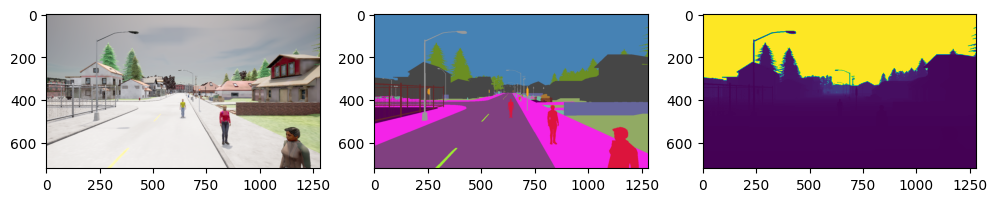

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

world.tick()

#rgb camera
image = image_queue.get()

#semantic segmentation camera
image_seg  = image_queue_seg.get()

#depth camera
image_depth = image_queue_depth.get()


image.save_to_disk("test_images2/carla_v2/view0/pointcloud-%d.png" %(image.frame))
image_seg.save_to_disk("test_images2/%d_semseg.png" %(image.frame), carla.ColorConverter.CityScapesPalette)
image_depth.save_to_disk("test_images2/carla_v2/view0/depth-%d.png" %(image.frame), carla.ColorConverter.Depth)

print(image.frame)
img = mpimg.imread("test_images2/carla_v2/view0/pointcloud-%d.png" % image.frame)
img_semseg = mpimg.imread("test_images2/%d_semseg.png" % image.frame)
img_depth = mpimg.imread("test_images2/carla_v2/view0/depth-%d.png" % image.frame)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,18))
ax1.imshow(img)
ax2.imshow(img_semseg)
ax3.imshow(img_depth) 
plt.show()

### Interpreting the Segmentation Maps
Let's first read the segmentation maps in HSV color space since it is easier to process color-based segmentation in that format.

In the segmentation image, CARLA currently supports only certain objects and not all the objects we listed in the blueprint. The list of supported objects are at https://carla.readthedocs.io/en/0.9.9/ref_sensors/. Shown below are the RGB values for some of the common supported objects we could be interested in. 


### As an example, let's get the bounding boxes of cars from the segmentation images

Refer to the helper functions `get_mask` and `get_bbox_from_mask` we defined above.

`get_mask()` isolates the object's mask from the segmentation image.

`get_bbox_from_mask()` computes the bounding boxes from the isolates object's mask. 


#### Let's visualize the car segmentation mask and the bboxes

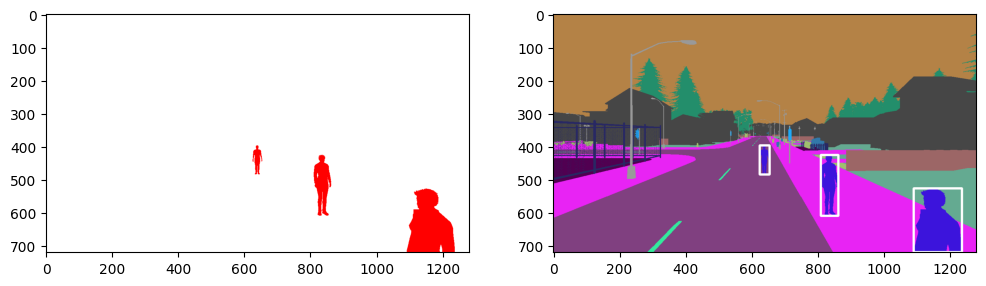

In [16]:
img_semseg_bgr = cv2.imread("test_images2/%d_semseg.png" % image.frame)
img_semseg_bgr = cv2.cvtColor(img_semseg_bgr, cv2.COLOR_BGRA2BGR)
img_semseg_hsv = cv2.cvtColor(img_semseg_bgr, cv2.COLOR_BGR2HSV) # color wise segmentation is better in hsv space


mask = get_mask(img_semseg_hsv, object_list['pedestrian'])
bboxes = get_bbox_from_mask(mask)


from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("custom_red_white", ["white", "red"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,18))
ax1.imshow(mask, cmap=cmap)
for bbox in bboxes:
    minr, minc, maxr, maxc = bbox
    cv2.rectangle(img_semseg_bgr, (minc,minr), (maxc, maxr), (255,255,255), 6)

ax2.imshow(img_semseg_bgr)
plt.show()

plt.imsave("test_images2/carla_v2_ground_truth/view0/pointcloud-%d.png" %(image.frame), mask, cmap=cmap)

#### Loop to save a sequence of frames

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

start_frame = 67 - 7
end_frame = 245 + 1 - start_frame

os.makedirs('test_images2/carla_v2/view0/', exist_ok=True)
os.makedirs('test_images2/carla_v2_ground_truth/view0/', exist_ok=True)

In [ ]:
# Skip initial frames of car spawning and not moving
for _ in range(start_frame):
    vehicle.apply_control(carla.VehicleControl(throttle=0.25, steer=0.0, reverse=False))
    world.tick()

    image = image_queue.get()
    print(image, type(image))
    image_seg  = image_queue_seg.get()
    image_depth = image_queue_depth.get()

# Save frames from scenario we want
for _ in range(end_frame):
    vehicle.apply_control(carla.VehicleControl(throttle=0.25, steer=0.0, reverse=False))
    world.tick()

    #rgb camera
    image = image_queue.get()

    #semantic segmentation camera
    image_seg  = image_queue_seg.get()

    #depth camera
    image_depth = image_queue_depth.get()


    image.save_to_disk("test_images2/carla_v2/view0/pointcloud-%d.png" %(image.frame))
    image_seg.save_to_disk("test_images2/%d_semseg.png" %(image.frame), carla.ColorConverter.CityScapesPalette)
    image_depth.save_to_disk("test_images2/carla_v2/view0/depth-%d.png" %(image.frame), carla.ColorConverter.Depth)

    print(image.frame)
    # img = mpimg.imread("test_images2/carla_v2/view0/pointcloud-%d.png" % image.frame)
    # img_semseg = mpimg.imread("test_images2/%d_semseg.png" % image.frame)
    # img_depth = mpimg.imread("test_images2/carla_v2/view0/depth-%d.png" % image.frame)

    # fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,18))
    # ax1.imshow(img)
    # ax2.imshow(img_semseg)
    # ax3.imshow(img_depth) 
    # plt.show()


    img_semseg_bgr = cv2.imread("test_images2/%d_semseg.png" % image.frame)
    img_semseg_bgr = cv2.cvtColor(img_semseg_bgr, cv2.COLOR_BGRA2BGR)
    img_semseg_hsv = cv2.cvtColor(img_semseg_bgr, cv2.COLOR_BGR2HSV) # color wise segmentation is better in hsv space


    mask = get_mask(img_semseg_hsv, object_list['pedestrian'])
    bboxes = get_bbox_from_mask(mask)


    from matplotlib.colors import LinearSegmentedColormap
    cmap = LinearSegmentedColormap.from_list("custom_red_white", ["white", "red"])

    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,18))
    # ax1.imshow(mask, cmap=cmap)
    # for bbox in bboxes:
    #     minr, minc, maxr, maxc = bbox
    #     cv2.rectangle(img_semseg_bgr, (minc,minr), (maxc, maxr), (255,255,255), 6)

    # ax2.imshow(img_semseg_bgr)
    # plt.show()
    

    plt.imsave("test_images2/carla_v2_ground_truth/view0/pointcloud-%d.png" %(image.frame), mask, cmap=cmap)

### Driving the vehicle

In order to auto-pilot the vehicle to just drive around and get data, we can choose the next random waypoint on the map and set the vehicle location to that waypoint. 

In [ ]:
# waypoint = world.get_map().get_waypoint(vehicle.get_location(), project_to_road=True, lane_type=carla.LaneType.Driving)
# waypoint = random.choice(waypoint.next(1.5))
# vehicle.set_transform(waypoint.transform)

Now, we can repeat the steps above to get the sensor data again. 

We can also control the vehicle's accelaration and steering using python. This is especially useful if you would like an AI agent to control the vehicle. I will update how to do so soon. 


### Finally, we need to destroy all the actors in the simulation 

In [29]:
#make sure to destroy all cameras and actors since they remain in the simulator even if you respawn using python. 
#It gets destroyed only if you restart CARLA simulator
camera.destroy()
camera_d.destroy()
camera_seg.destroy()
client.apply_batch([carla.command.DestroyActor(x) for x in actor_list])